In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
print ("Ready!")


['train_identity.csv', 'test_transaction.csv', 'train_transaction.csv', 'test_identity.csv', 'sample_submission.csv']
Ready!


In [3]:
pd.set_option('display.max_columns',50)

In [2]:
# Transaction CSVs
train_transaction = pd.read_csv('../input/train_transaction.csv')
test_transaction = pd.read_csv('../input/test_transaction.csv')
# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('../input/train_identity.csv')
test_identity = pd.read_csv('../input/test_identity.csv')
# Sample Submissions
sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_transaction=reduce_mem_usage(train_transaction,verbose=True)
train_identity=reduce_mem_usage(train_identity,verbose=True)
test_transaction=reduce_mem_usage(test_transaction,verbose=True)
test_identity=reduce_mem_usage(test_identity,verbose=True)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [9]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

In [15]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,...,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [17]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [19]:
missing_df = train_transaction.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count',ascending=False)
missing_df.head()

,column_name,missing_count
14,dist2,552913
37,D7,551623
43,D13,528588
44,D14,528353
42,D12,525823


In [30]:
missing_df=train_identity.isnull().sum().reset_index()
missing_df.columns=['column_name','missing_count']
missing_df=missing_df.loc[missing_df['missing_count']>0]
missing_df=missing_df.sort_values(by='missing_count',ascending=False)
missing_df.head()


,column_name,missing_count
24,id_24,139486
25,id_25,139101
7,id_07,139078
8,id_08,139078
21,id_21,139074


In [35]:
train_identity.isnull().sum().reset_index().sum()

index    TransactionIDid_01id_02id_03id_04id_05id_06id_...
0                                                  2104107
dtype: object

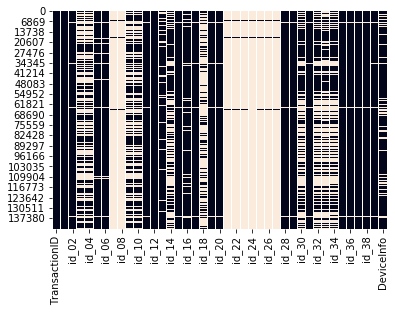

In [36]:
sns.heatmap(train_identity.isnull(),cbar=False)
plt.figsize=(5,8)
plt.show()

<BarContainer object of 2 artists>

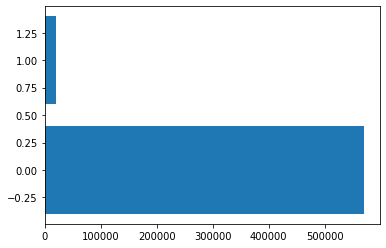

In [21]:
index=train_transaction['isFraud'].value_counts().index
counts=train_transaction['isFraud'].value_counts().values
plt.barh(index,counts)

In [35]:
(train_transaction['TransactionDT'].max()-train_transaction['TransactionDT'].min())/(60*60*24*365)

0.4986279490106545

In [44]:
print(train_transaction.index.isin(train_identity.index.unique()).sum())
print(test_transaction.index.isin(test_identity.index.unique()).sum())

144233
141907


In [54]:
print(train_transaction['TransactionDT'].shape[0])
print(train_transaction['TransactionDT'].nunique())
train_transaction['TransactionDT'].value_counts().head()

590540
573349


9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
Name: TransactionDT, dtype: int64

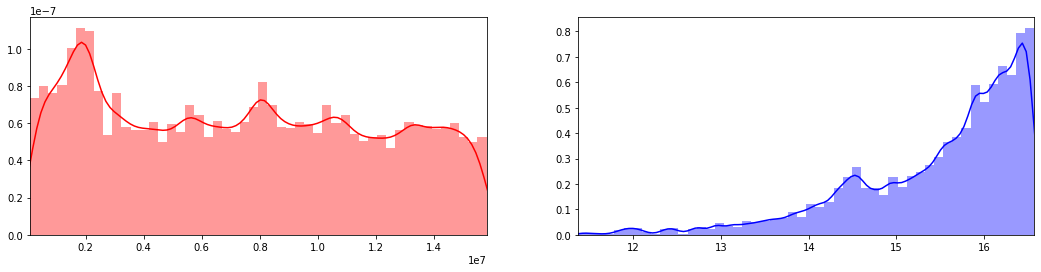

In [57]:
fig,ax=plt.subplots(1,2,figsize=(18,4))
time_val=train_transaction['TransactionDT'].values
sns.distplot(time_val,ax=ax[0],color='r')
ax[0].set_xlim([min(time_val),max(time_val)])

sns.distplot(np.log(time_val),ax=ax[1],color='b')
ax[1].set_xlim([min(np.log(time_val)),max(np.log(time_val))])
plt.show()

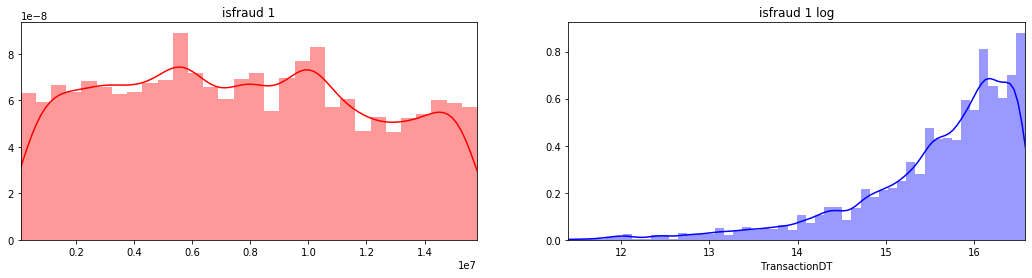

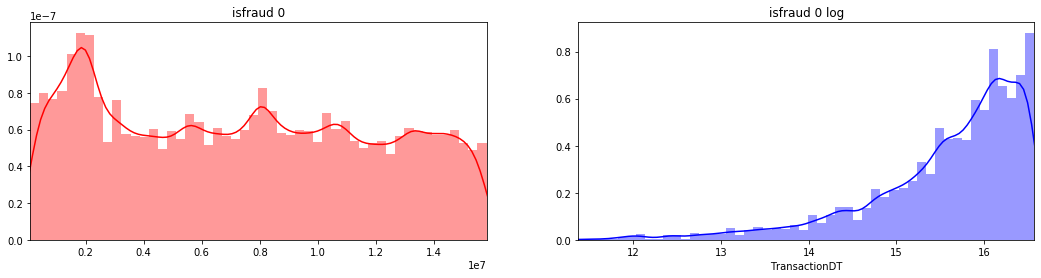

In [60]:
time_val_fraud=train_transaction[train_transaction['isFraud']==1]['TransactionDT'].values
fig,ax=plt.subplots(1,2,figsize=(18,4))
sns.distplot(time_val_fraud,ax=ax[0],color='r')
ax[0].set_xlim([min(time_val_fraud),max(time_val_fraud)])
ax[0].set_title('isfraud 1')
sns.distplot(np.log(time_val),ax=ax[1],color='b')
ax[1].set_xlim([min(np.log(time_val_fraud)),max(np.log(time_val_fraud))])
ax[1].set_title('isfraud 1 log')
plt.show()


time_val_notfraud=train_transaction[train_transaction['isFraud']==0]['TransactionDT'].values
fig,ax=plt.subplots(1,2,figsize=(18,4))
sns.distplot(time_val_notfraud,ax=ax[0],color='r')
ax[0].set_xlim([min(time_val_notfraud),max(time_val_fraud)])
ax[0].set_title('isfraud 0')

sns.distplot(np.log(time_val),ax=ax[1],color='b')
ax[1].set_xlim([min(np.log(time_val_notfraud)),max(np.log(time_val_fraud))])
ax[1].set_title('isfraud 0 log')
plt.show()



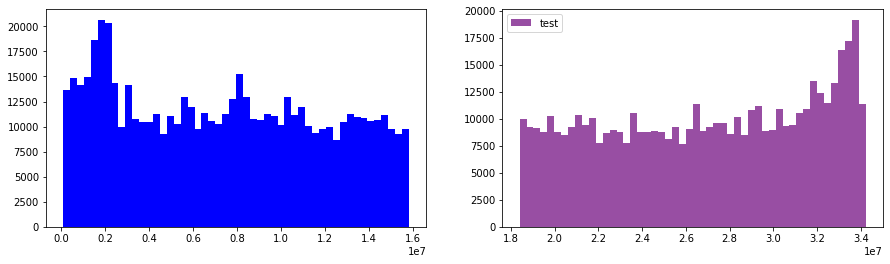

In [71]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

ax[0].hist(train_transaction['TransactionDT'],color='b',bins=50,label='train')
ax[1].hist(test_transaction['TransactionDT'],color='#984ea3',bins=50,label='test')
plt.legend()
plt.show()

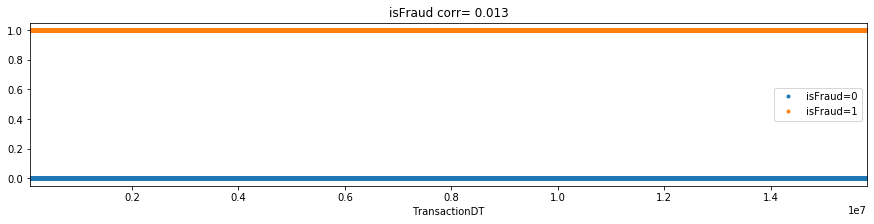

In [73]:
i = 'isFraud'
cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

In [75]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,...,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


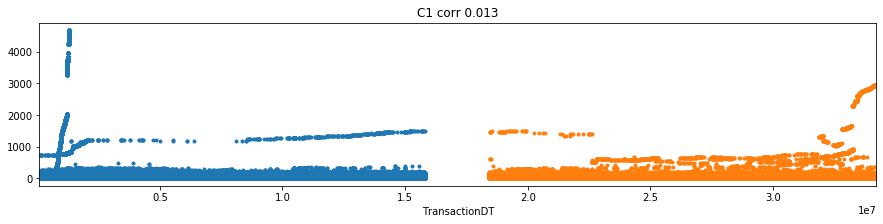

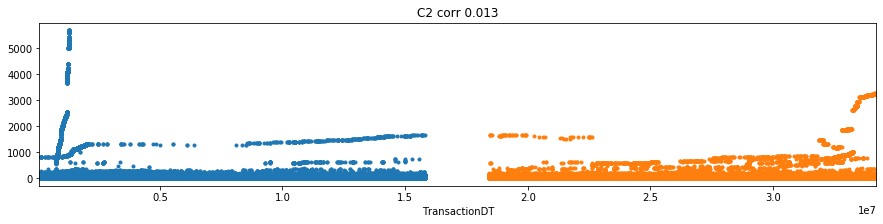

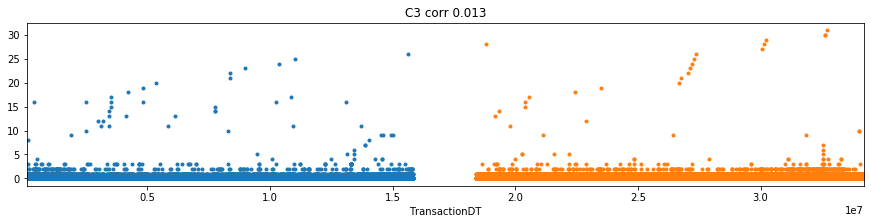

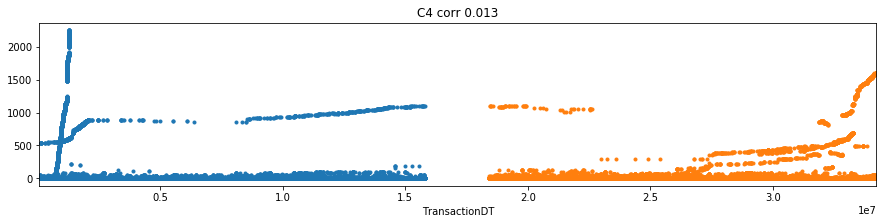

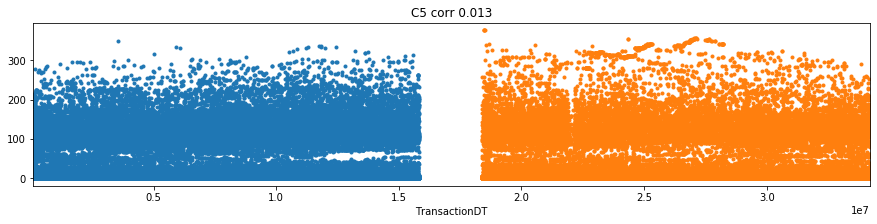

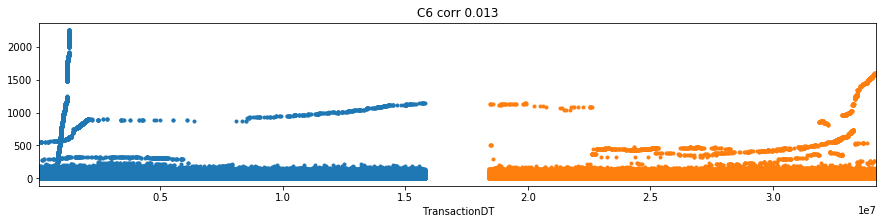

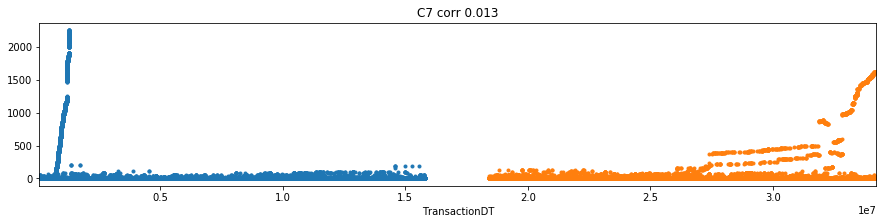

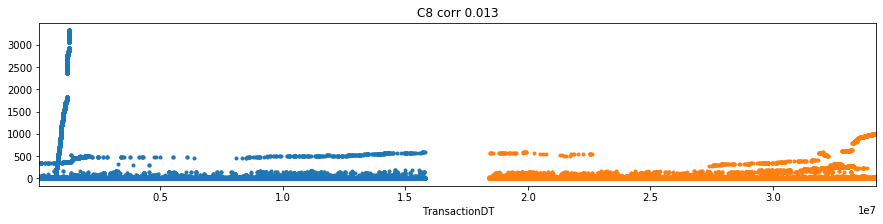

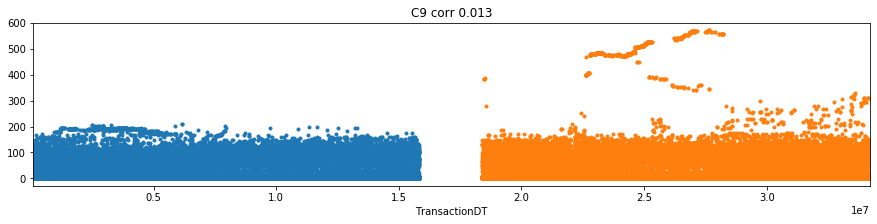

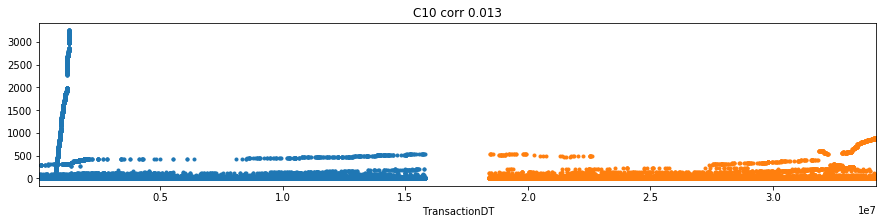

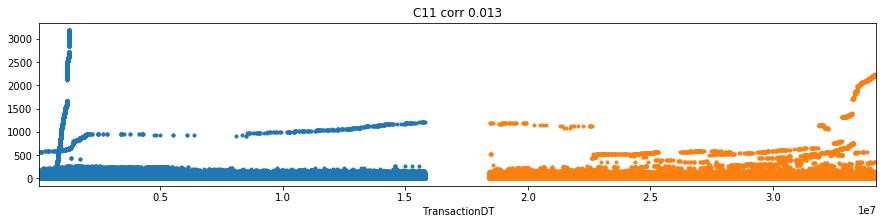

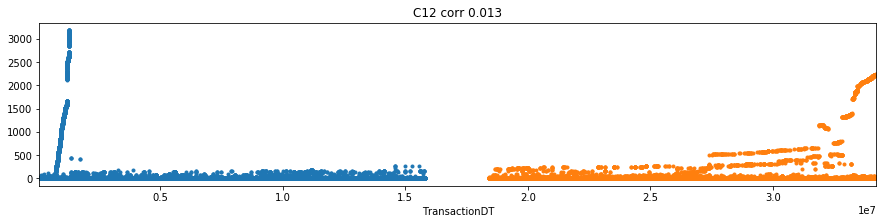

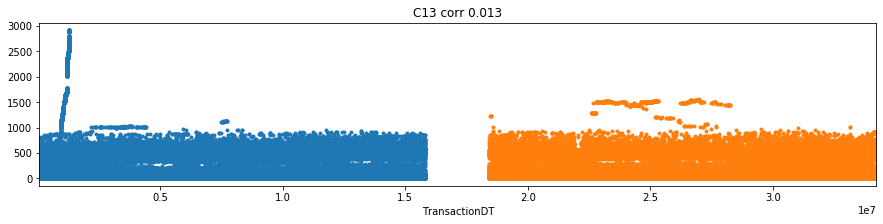

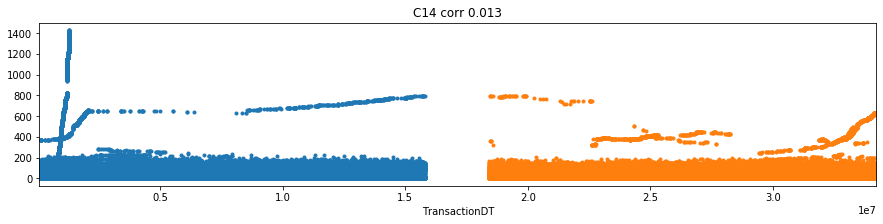

In [93]:
c_cols=[col for col in train_transaction.columns if col[0] == 'C']

for col in c_cols:
    cor=np.corrcoef(train_transaction['TransactionDT'],train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[col].plot(style='.',title=col+' corr '+str(round(cor,3)),figsize=(15,3))
    test_transaction.set_index('TransactionDT')[col].plot(style='.',title=col+' corr '+str(round(cor,3)),figsize=(15,3))
    plt.show()

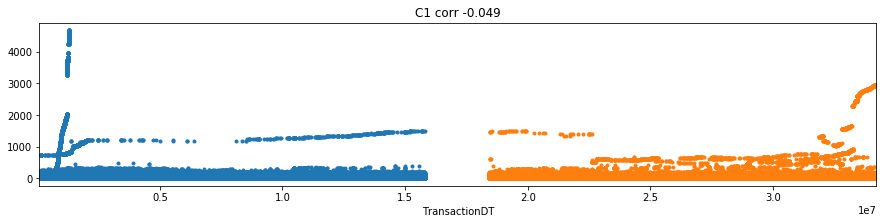

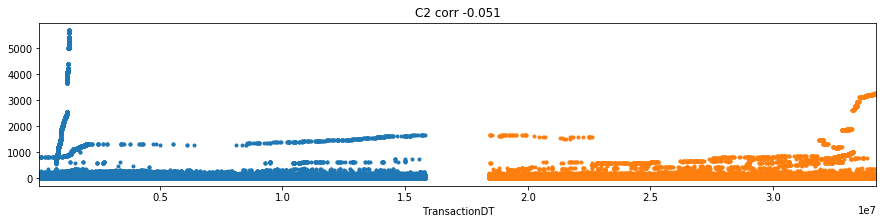

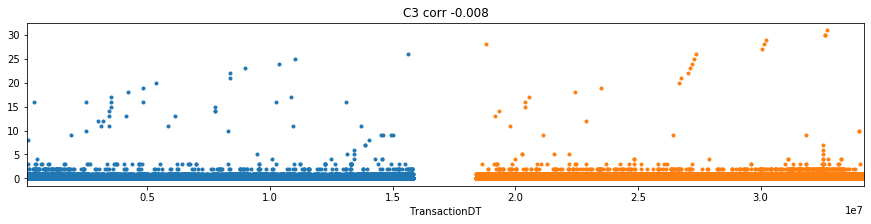

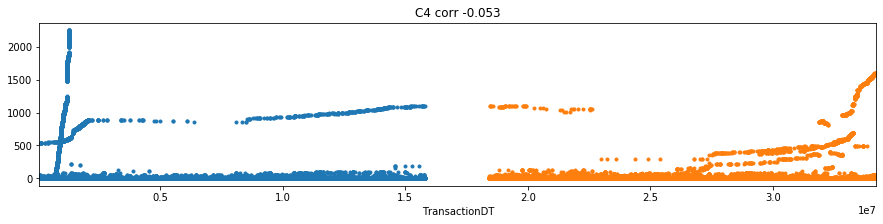

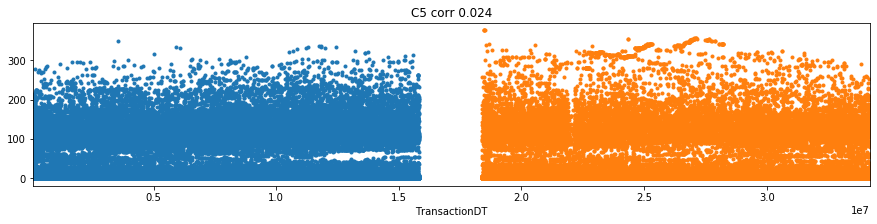

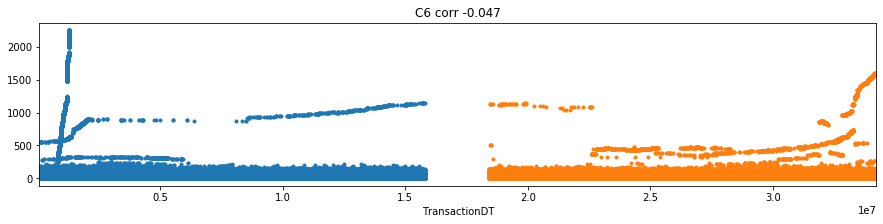

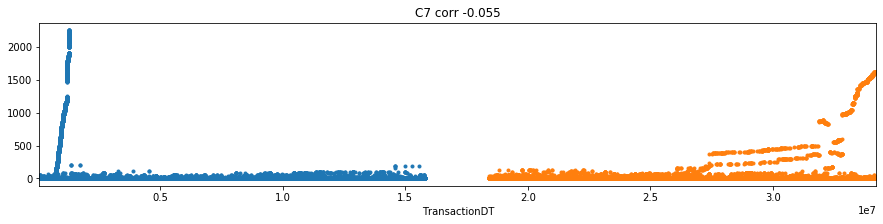

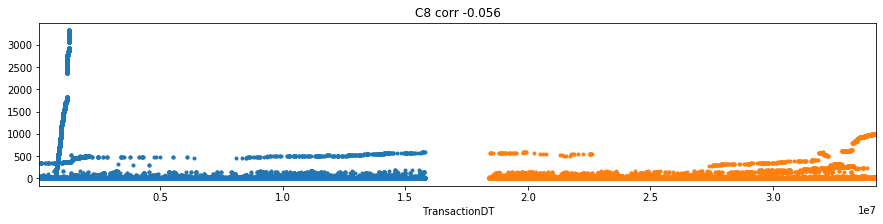

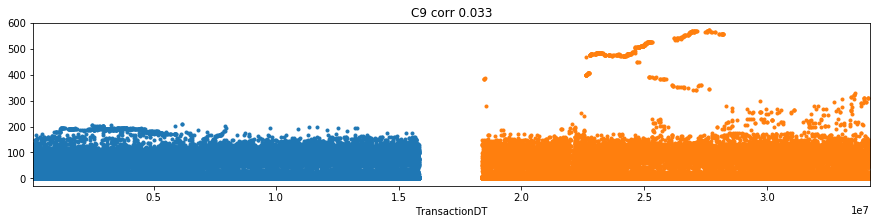

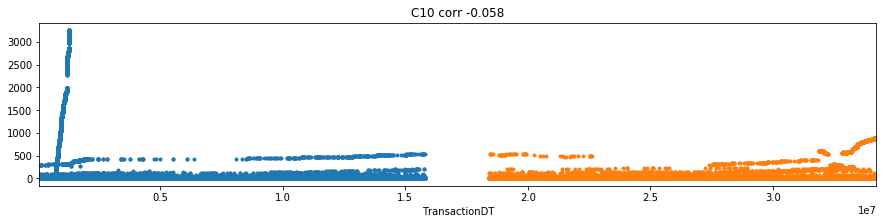

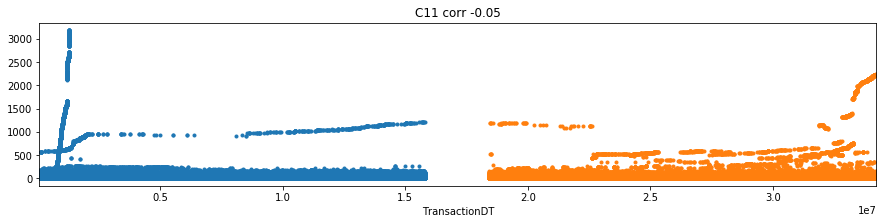

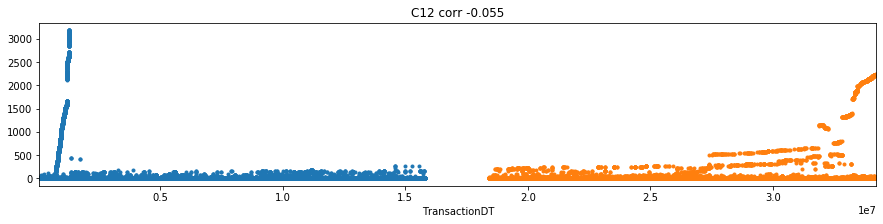

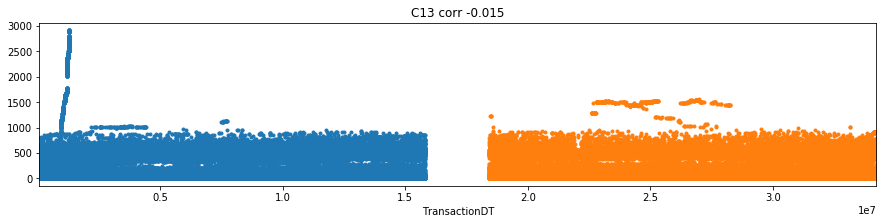

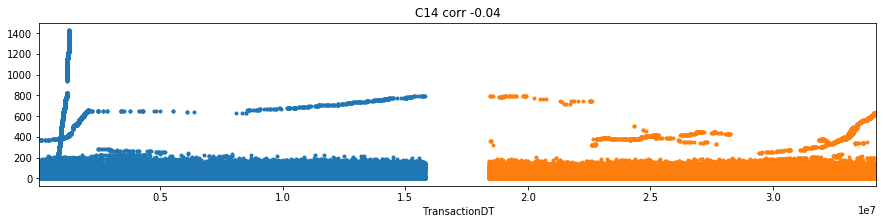

In [97]:
d_cols=[col for col in train_transaction.columns if col[0]=='D']
for col in c_cols:
    cor=np.corrcoef(train_transaction['TransactionDT'],train_transaction[col])[0,1]
    train_transaction.set_index('TransactionDT')[col].plot(style='.',title=col+' corr '+str(round(cor,3)),figsize=(15,3))
    test_transaction.set_index('TransactionDT')[col].plot(style='.',title=col+' corr '+str(round(cor,3)),figsize=(15,3))
    plt.show()

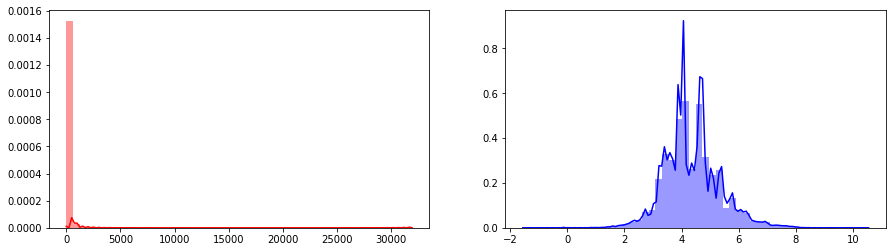

In [105]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
time_val=train_transaction['TransactionAmt'].values
sns.distplot(time_val,ax=ax[0],color='r')
sns.distplot(np.log(time_val),ax=ax[1],color='b')

plt.show()

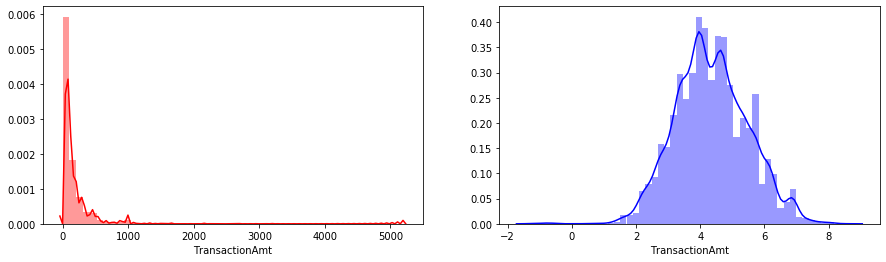

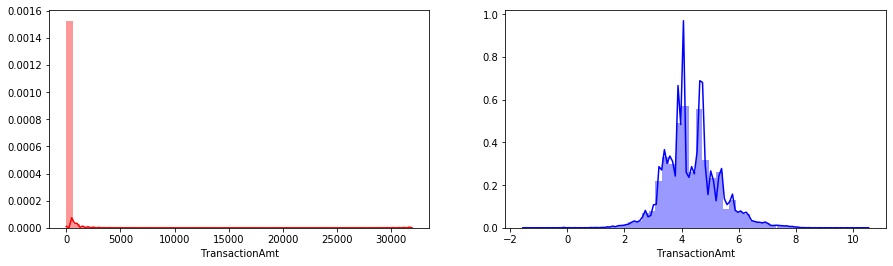

In [112]:
time_val_fraud=train_transaction[train_transaction['isFraud']==1]['TransactionAmt']
fig,ax=plt.subplots(1,2,figsize=(15,4))
sns.distplot(time_val_fraud,color='r',ax=ax[0])
sns.distplot(np.log(time_val_fraud),color='b',ax=ax[1])
plt.show()

time_val_nonfraud=train_transaction[train_transaction['isFraud']==0]['TransactionAmt']
fig,ax=plt.subplots(1,2,figsize=(15,4))
sns.distplot(time_val_nonfraud,color='r',ax=ax[0])
sns.distplot(np.log(time_val_nonfraud),color='b',ax=ax[1])
plt.show()

In [122]:
pd.set_option('display.max_columns',1000)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

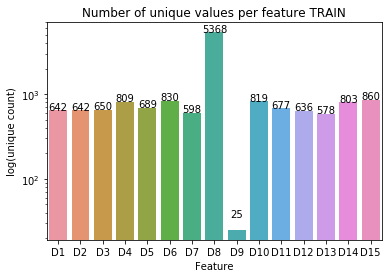

In [125]:
uniques=[len(train_transaction[col].unique()) for col in d_cols]
ax=sns.barplot(d_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

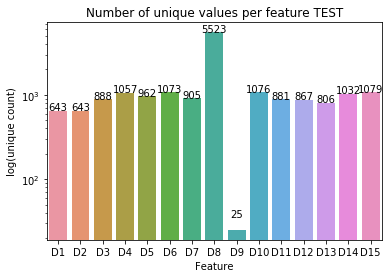

In [126]:
uniques=[len(test_transaction[col].unique()) for col in d_cols]
ax=sns.barplot(d_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

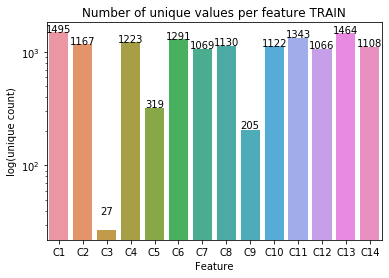

In [127]:
uniques=[len(train_transaction[col].unique()) for col in c_cols]
ax=sns.barplot(c_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

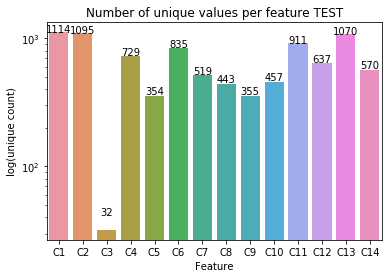

In [128]:
uniques=[len(test_transaction[col].unique()) for col in c_cols]
ax=sns.barplot(c_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [130]:
v_cols=[col for col in train_transaction.columns if col[0]=='V']
train_transaction[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

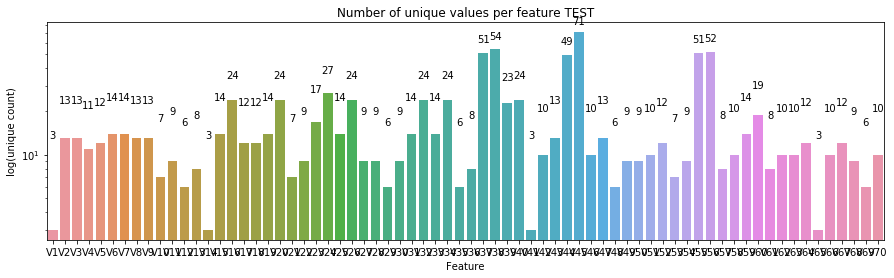

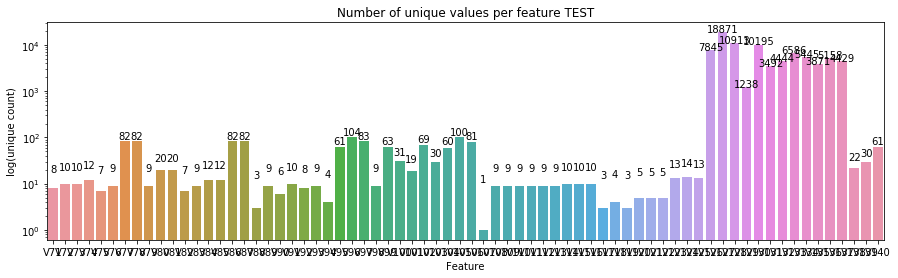

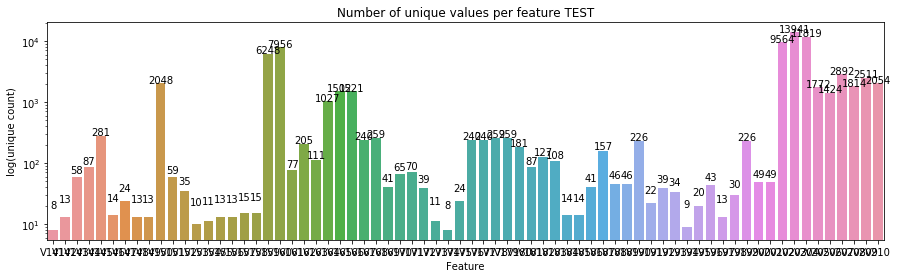

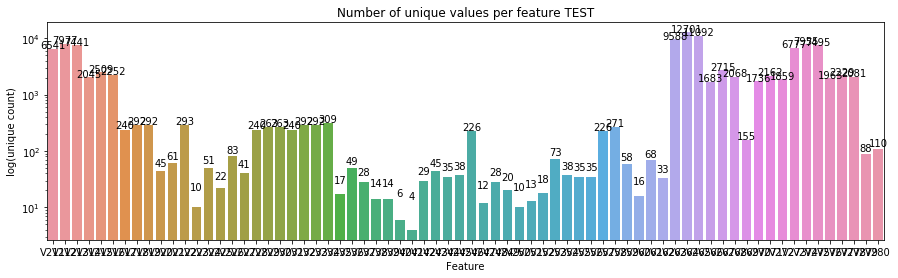

In [141]:
for i in range(len(v_cols)//70):
    plt.figure(figsize=(15,4))
    cols=[col for col in v_cols[i*70:(i+1)*70]]
    uniques=[len(test_transaction[col].unique()) for col in v_cols[i*70:(i+1)*70]]
    ax=sns.barplot(cols,uniques,log=True)
    ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
    for p, uniq in zip(ax.patches, uniques):
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 10,
                uniq,
                ha="center") 
    plt.show()

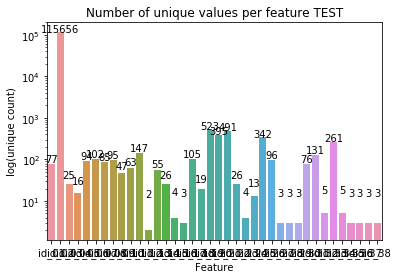

In [149]:
id_cols=[col for col in train_identity.columns if col[0]=='i']

uniques=[len(train_identity[col].unique()) for col in id_cols]
ax=sns.barplot(id_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

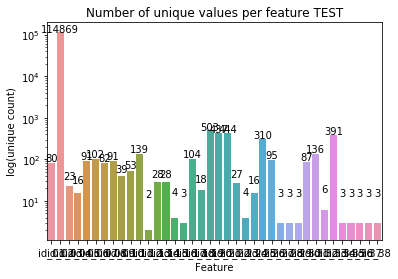

In [150]:
uniques=[len(test_identity[col].unique()) for col in id_cols]
ax=sns.barplot(id_cols,uniques,log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

## categorical features

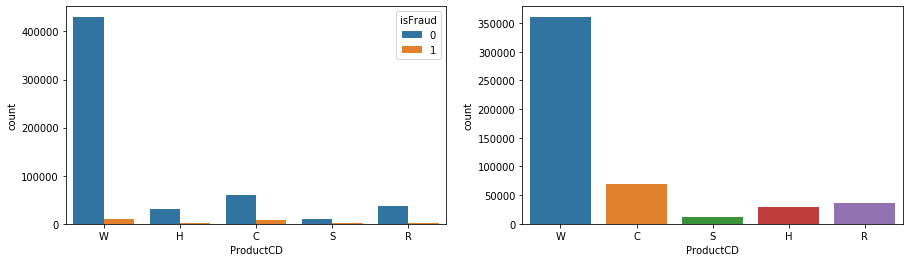

In [154]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
sns.countplot(x='ProductCD',data=train_transaction,hue='isFraud',ax=ax[0])
sns.countplot(x='ProductCD',data=test_transaction,ax=ax[1])
plt.show()

In [156]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


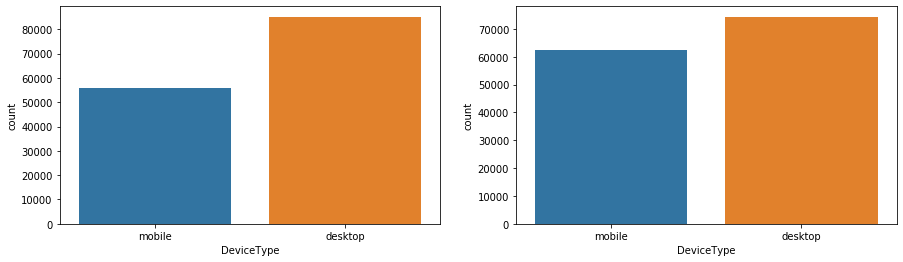

In [157]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
sns.countplot(x='DeviceType',data=train_identity,ax=ax[0])
sns.countplot(x='DeviceType',data=test_identity,ax=ax[1])
plt.show()

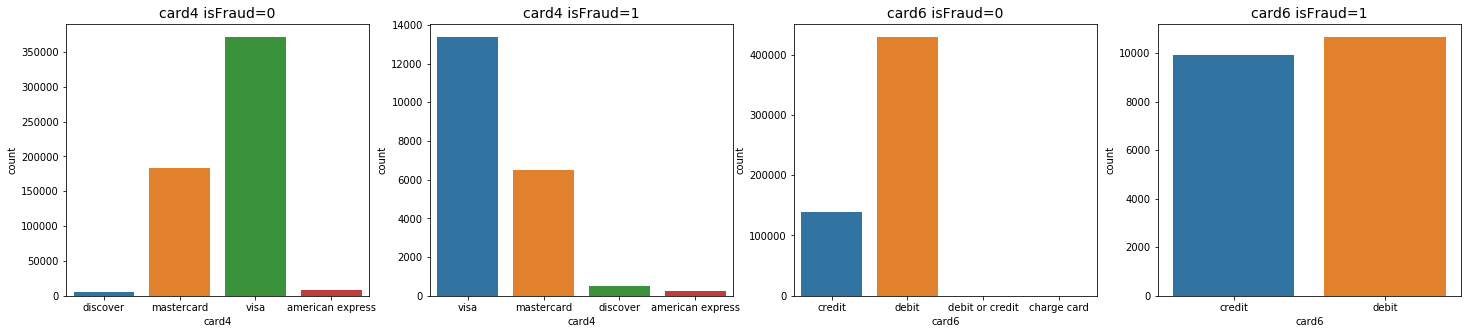

In [186]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

In [4]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype("uint8").copy()
print("Tain: ",train.shape)
del train_transaction, train_identity

test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print("Test: ",test.shape)
del test_transaction, test_identity
print ("Merged!")

Tain:  (590540, 435)
Test:  (506691, 434)
Merged!


In [5]:
X_train=train.drop('isFraud',axis=1)
X_test=test.copy()
del train, test
gc.collect()

60

In [9]:
X_train.select_dtypes(include='object').columns.isin(X_test.select_dtypes(include='object').columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [6]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

In [7]:
X_train=reduce_mem_usage(X_train)
X_test=reduce_mem_usage(X_test)

Mem. usage decreased to 527.14 Mb (73.0% reduction)
Mem. usage decreased to 460.02 Mb (72.6% reduction)


In [9]:
np.save('X_train',X_train)
np.save('X_test',X_test)
np.save('y_train',y_train)

In [26]:
one_value_cols=[col for col in X_train.columns if X_train[col].unique==1]
one_value_cols_test=[col for col in X_test.columns if X_test[col].unique==1]
print(one_value_cols)
print(one_value_cols_test)

[]
[]


In [10]:
X_train=X_train.fillna(-999)
X_test=X_test.fillna(-999)

In [30]:
xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.1,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-1, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [31]:
%%time
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

FOLD:  0  AUC 0.9623629520333516
FOLD:  1  AUC 0.96460223410378
FOLD:  2  AUC 0.9625928999184656
FOLD:  3  AUC 0.9615839067729184
FOLD:  4  AUC 0.9624441861220647

MEAN AUC = 0.9627172357901161
OOF AUC = 0.9627126464172155
CPU times: user 4min 9s, sys: 1min 22s, total: 5min 32s
Wall time: 5min 30s


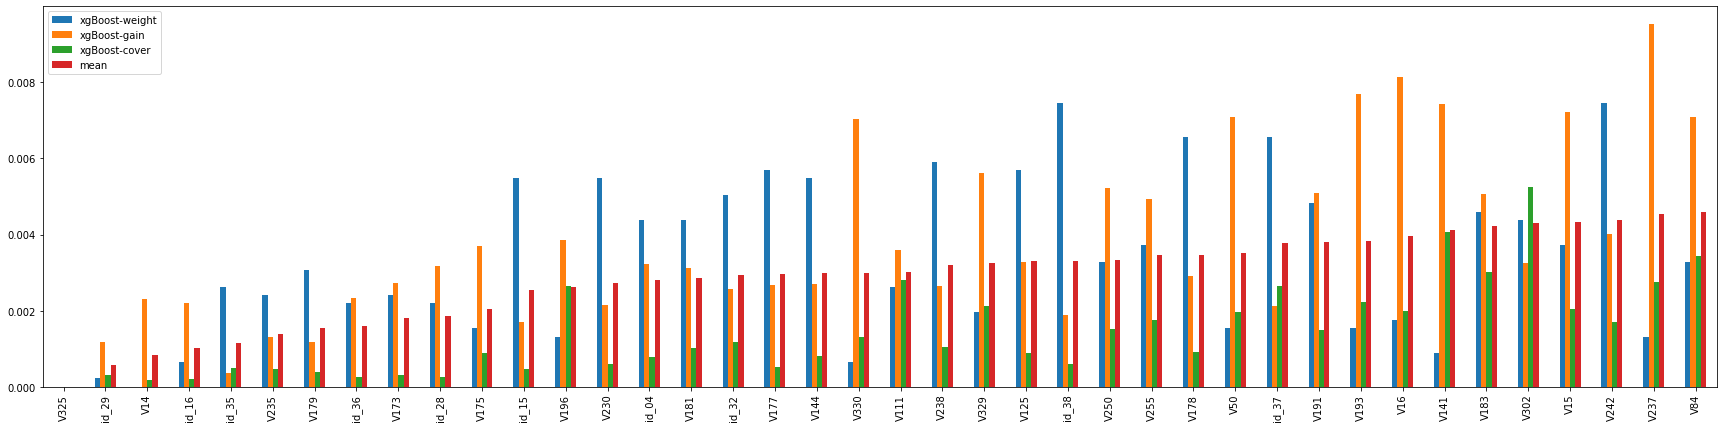

In [34]:
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').head(40).plot(kind='bar', figsize=(30, 7))

In [35]:
del clf, importance_df
gc.collect()

92571

In [36]:
sub=pd.read_csv('../input/sample_submission.csv',index_col='TransactionID')
sub['isFraud']=y_preds
sub.to_csv('EDA_xgboost.csv')

In [37]:
sub.head()

,isFraud
TransactionID,
3663549,0.004470
3663550,0.000957
3663551,0.003399
3663552,0.001887
3663553,0.001788


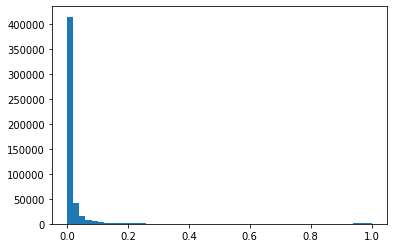

In [39]:
sub.loc[sub['isFraud']>0.99,'isFraud']=1
plt.hist(sub['isFraud'],bins=50)
plt.show()

In [ ]:
%%time

param = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }

NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_vl, label=y_vl)
    clf = lgb.train(param, train_data, 100000, valid_sets = [train_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    
    y_pred_train= clf.predict(val_data, num_iteration=clf.best_iteration)
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict(X_test,num_iteration=clf.best_iteration) / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

Training until validation scores don't improve for 4000 rounds.
